# 복습
- 1. EDA(탐색적 데이터 분석)
- 2. Feature Engineering(스케일링, 인코딩)
- 3. 하이퍼 파라미터 세팅(교차검증)
- 4. 모델 생성
- 5. 모델 훈련(fit)
- 6. 예측(predict), 검증(score)

# 타이타닉 생존률 예측

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path=r'./train_final.csv'
train_final = pd.read_csv(path)

path=r'./test_final.csv'
test_final = pd.read_csv(path)

In [6]:
train_final.columns

feature_names = ['Age_s', 'Fare_s',
                'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S',
                'Name_c_Master', 'Name_c_Mr', 'Name_c_Woman', 'Family_c_Big_f',
                'Family_c_Small_f']

In [9]:
# feature => 2차원
# target => 1차원

X = train_final[feature_names]
y = train_final['Survived']

In [13]:
test_final[feature_names]

Age_s    Fare_s  Pclass_2  Pclass_3  Sex_male  Embarked_Q  Embarked_S  \
0    0.390349 -0.809683         0         1         1           1           0   
1    1.332065 -0.911513         0         1         0           0           1   
2    2.462123 -0.612461         1         0         1           1           0   
3   -0.174680 -0.716562         0         1         1           0           1   
4   -0.551366 -0.387631         0         1         0           0           1   
..        ...       ...       ...       ...       ...         ...         ...   
413 -0.211777 -0.784179         0         1         1           0           1   
414  0.729367  1.793823         0         0         0           0           0   
415  0.691698 -0.879741         0         1         1           0           1   
416 -0.211777 -0.784179         0         1         1           0           1   
417 -0.211777  0.194843         0         1         1           0           0   

     Name_c_Master  Name_c_Mr  Name_c_Woman  Family_c_Big_f  Family_c_Small_f  
0                0          1             0               0                 0  
1                0          0             1               0                 1  
2                0          1             0               0                 0  
3                0          1             0               0                 0  
4                0          0             1               0                 1  
..             ...        ...           ...             ...               ...  
413              0          1             0               0                 0  
414              0          0             0               0                 0  
415              0          1             0               0                 0  
416              0          1             0               0                 0  
417              1          0             0               0                 1  

[418 rows x 12 columns]

In [18]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=1, 
                                                      stratify=y) # stratify : 훈련, 테스트의 카테고리 비율을 동일하게 맞춤

## KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [22]:
# KNN 모델의 하이퍼 파라미터 찾기

score_list = []

for k in range(1,51):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score( knn, train_x, train_y, cv=5 ).mean()
    score_list.append(score)

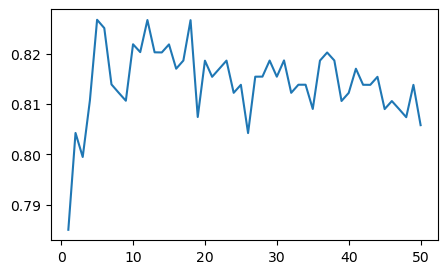

In [26]:
plt.figure(figsize=(5,3))

plt.plot(range(1,51), score_list)

plt.show()

In [27]:
# k=13으로 찾음!
# knn 모델 생성
knn = KNeighborsClassifier(n_neighbors=13)
# 훈련
knn.fit(train_x, train_y)
# 검증
knn.score(valid_x, valid_y)

0.8059701492537313

In [33]:
# test 데이터를 예측!
knn_result = pd.DataFrame( test_final['PassengerId'] )
knn_result['Survived'] = knn.predict( test_final[feature_names] )

In [35]:
knn_result.to_csv( r'knn_result.csv', index=False )

## SVM(서포트 벡터 머신)
- 하이퍼파라미터 C : 경계선 부근에서 틀리는 것에 대한 비용
    - 너무 높으면 아웃라이어도 틀리는 것을 허용못하고 포함 => 오버피팅
    - 너무 낮추면 전체 데이터 맥락도 다 틀려버림 => 언더피팅
- gamma : 고차원에서 데이터에 얼마나 핏한 평면을 만들 것인가
    - 너무 높으면 오버피팅
    - 너무 낮으면 언더피팅
    
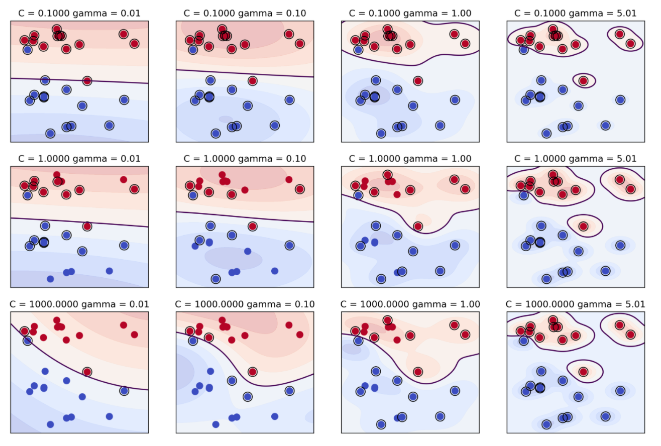

In [37]:
# C : 0.1,1,10
# gamma : 0.01,0.1,1,10

# for c in [0.1,1,10]:
#     for gamma in []

### gridsearch(그리드서치)
- 사이킷런에서 하이퍼파라미터가 여러개일 경우, 2중, 3중 for문 없이 최적의 파라미터를 찾을 수 있도록 지원

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [42]:
params = {'C':[0.01, 0.1, 1, 10],
        'gamma':[0.01, 0.1, 1, 10]}

# 1. grid 모델 생성
grid_svm = GridSearchCV( SVC(), params, cv=5 )
# 2. grid 모델 훈련
grid_svm.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10]})

In [43]:
# 결과 먼저 확인
grid_svm.best_params_

{'C': 1, 'gamma': 0.1}

In [52]:
# 종합적인 보고서
cv_result_svm = pd.DataFrame( grid_svm.cv_results_['params'] )
cv_result_svm['score'] = grid_svm.cv_results_['mean_test_score']
pd.pivot_table( cv_result_svm,
                index='C',
                columns='gamma',
                values='score',
                aggfunc='mean' )

gamma     0.01      0.10      1.00      10.00
C                                            
0.01   0.616374  0.616374  0.616374  0.616374
0.10   0.616374  0.794555  0.760800  0.616374
1.00   0.781677  0.829884  0.820335  0.757716
10.00  0.829884  0.817135  0.807497  0.759316

In [54]:
# grid_search가 베스트 파라미터 가지고 훈련 다 해놈...
# 바로 그 다음 작업을 진행
grid_svm.score( valid_x, valid_y )

0.8395522388059702

In [55]:
# test 데이터 예측

grid_svm.predict( test_final[feature_names] )

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [56]:
svm_result = pd.DataFrame( test_final['PassengerId'] )
svm_result['Survived'] = grid_svm.predict( test_final[feature_names] )

In [59]:
svm_result.to_csv('./svm_result.csv', index=False)

## Tree 모델
- gini 계수
- 분류의 경우, Tree 모델을 많이 사용
    - 해석력이 뛰어남
    - 다른 모델은 blackbox로 모델에 영향을 주는 feature를 구분하기 힘들지만,<br>
      Tree 모델의 경우, feture selection에 용이<br>
    - 수행이 쉬움

-  gini 계수
    - 데이터가 얼마나 순수한지
-  Max_depth
    - 1의 경우 제한 없이 트리 구분을 끝까지 진행 --> 오버피팅 우려
    - Tree를 몇개까지 남기고 구분을 해야하는지 지정해야하는 하이퍼 파라미터

In [71]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

params = {'max_depth':[3,5,10,30],
        'min_samples_leaf':[1,10,30,50]}

grid_tree = GridSearchCV( DecisionTreeClassifier(), params, cv=5 )
grid_tree.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 10, 30],
                         'min_samples_leaf': [1, 10, 30, 50]})

In [64]:
grid_tree.best_params_

{'max_depth': 5, 'min_samples_leaf': 1}

In [67]:
# 종합적인 보고서
cv_result_tree = pd.DataFrame( grid_tree.cv_results_['params'] )
cv_result_tree['score'] = grid_tree.cv_results_['mean_test_score']
pd.pivot_table( cv_result_tree,
                index='max_depth',
                columns='min_samples_leaf',
                values='score',
                aggfunc='mean' )

min_samples_leaf        1         10        30        50
max_depth                                               
3                 0.813832  0.809019  0.804194  0.775342
5                 0.825097  0.809110  0.796194  0.775342
10                0.799458  0.796219  0.796194  0.775342
30                0.813819  0.801019  0.796194  0.775342

In [69]:
tree = DecisionTreeClassifier( max_depth=3 )
tree.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=3)

In [70]:
# feature 영향성 확인
pd.Series( tree.feature_importances_, index=train_x.columns )

Age_s               0.003992
Fare_s              0.084032
Pclass_2            0.000000
Pclass_3            0.097282
Sex_male            0.000000
Embarked_Q          0.000000
Embarked_S          0.000000
Name_c_Master       0.000000
Name_c_Mr           0.624506
Name_c_Woman        0.000000
Family_c_Big_f      0.190187
Family_c_Small_f    0.000000
dtype: float64

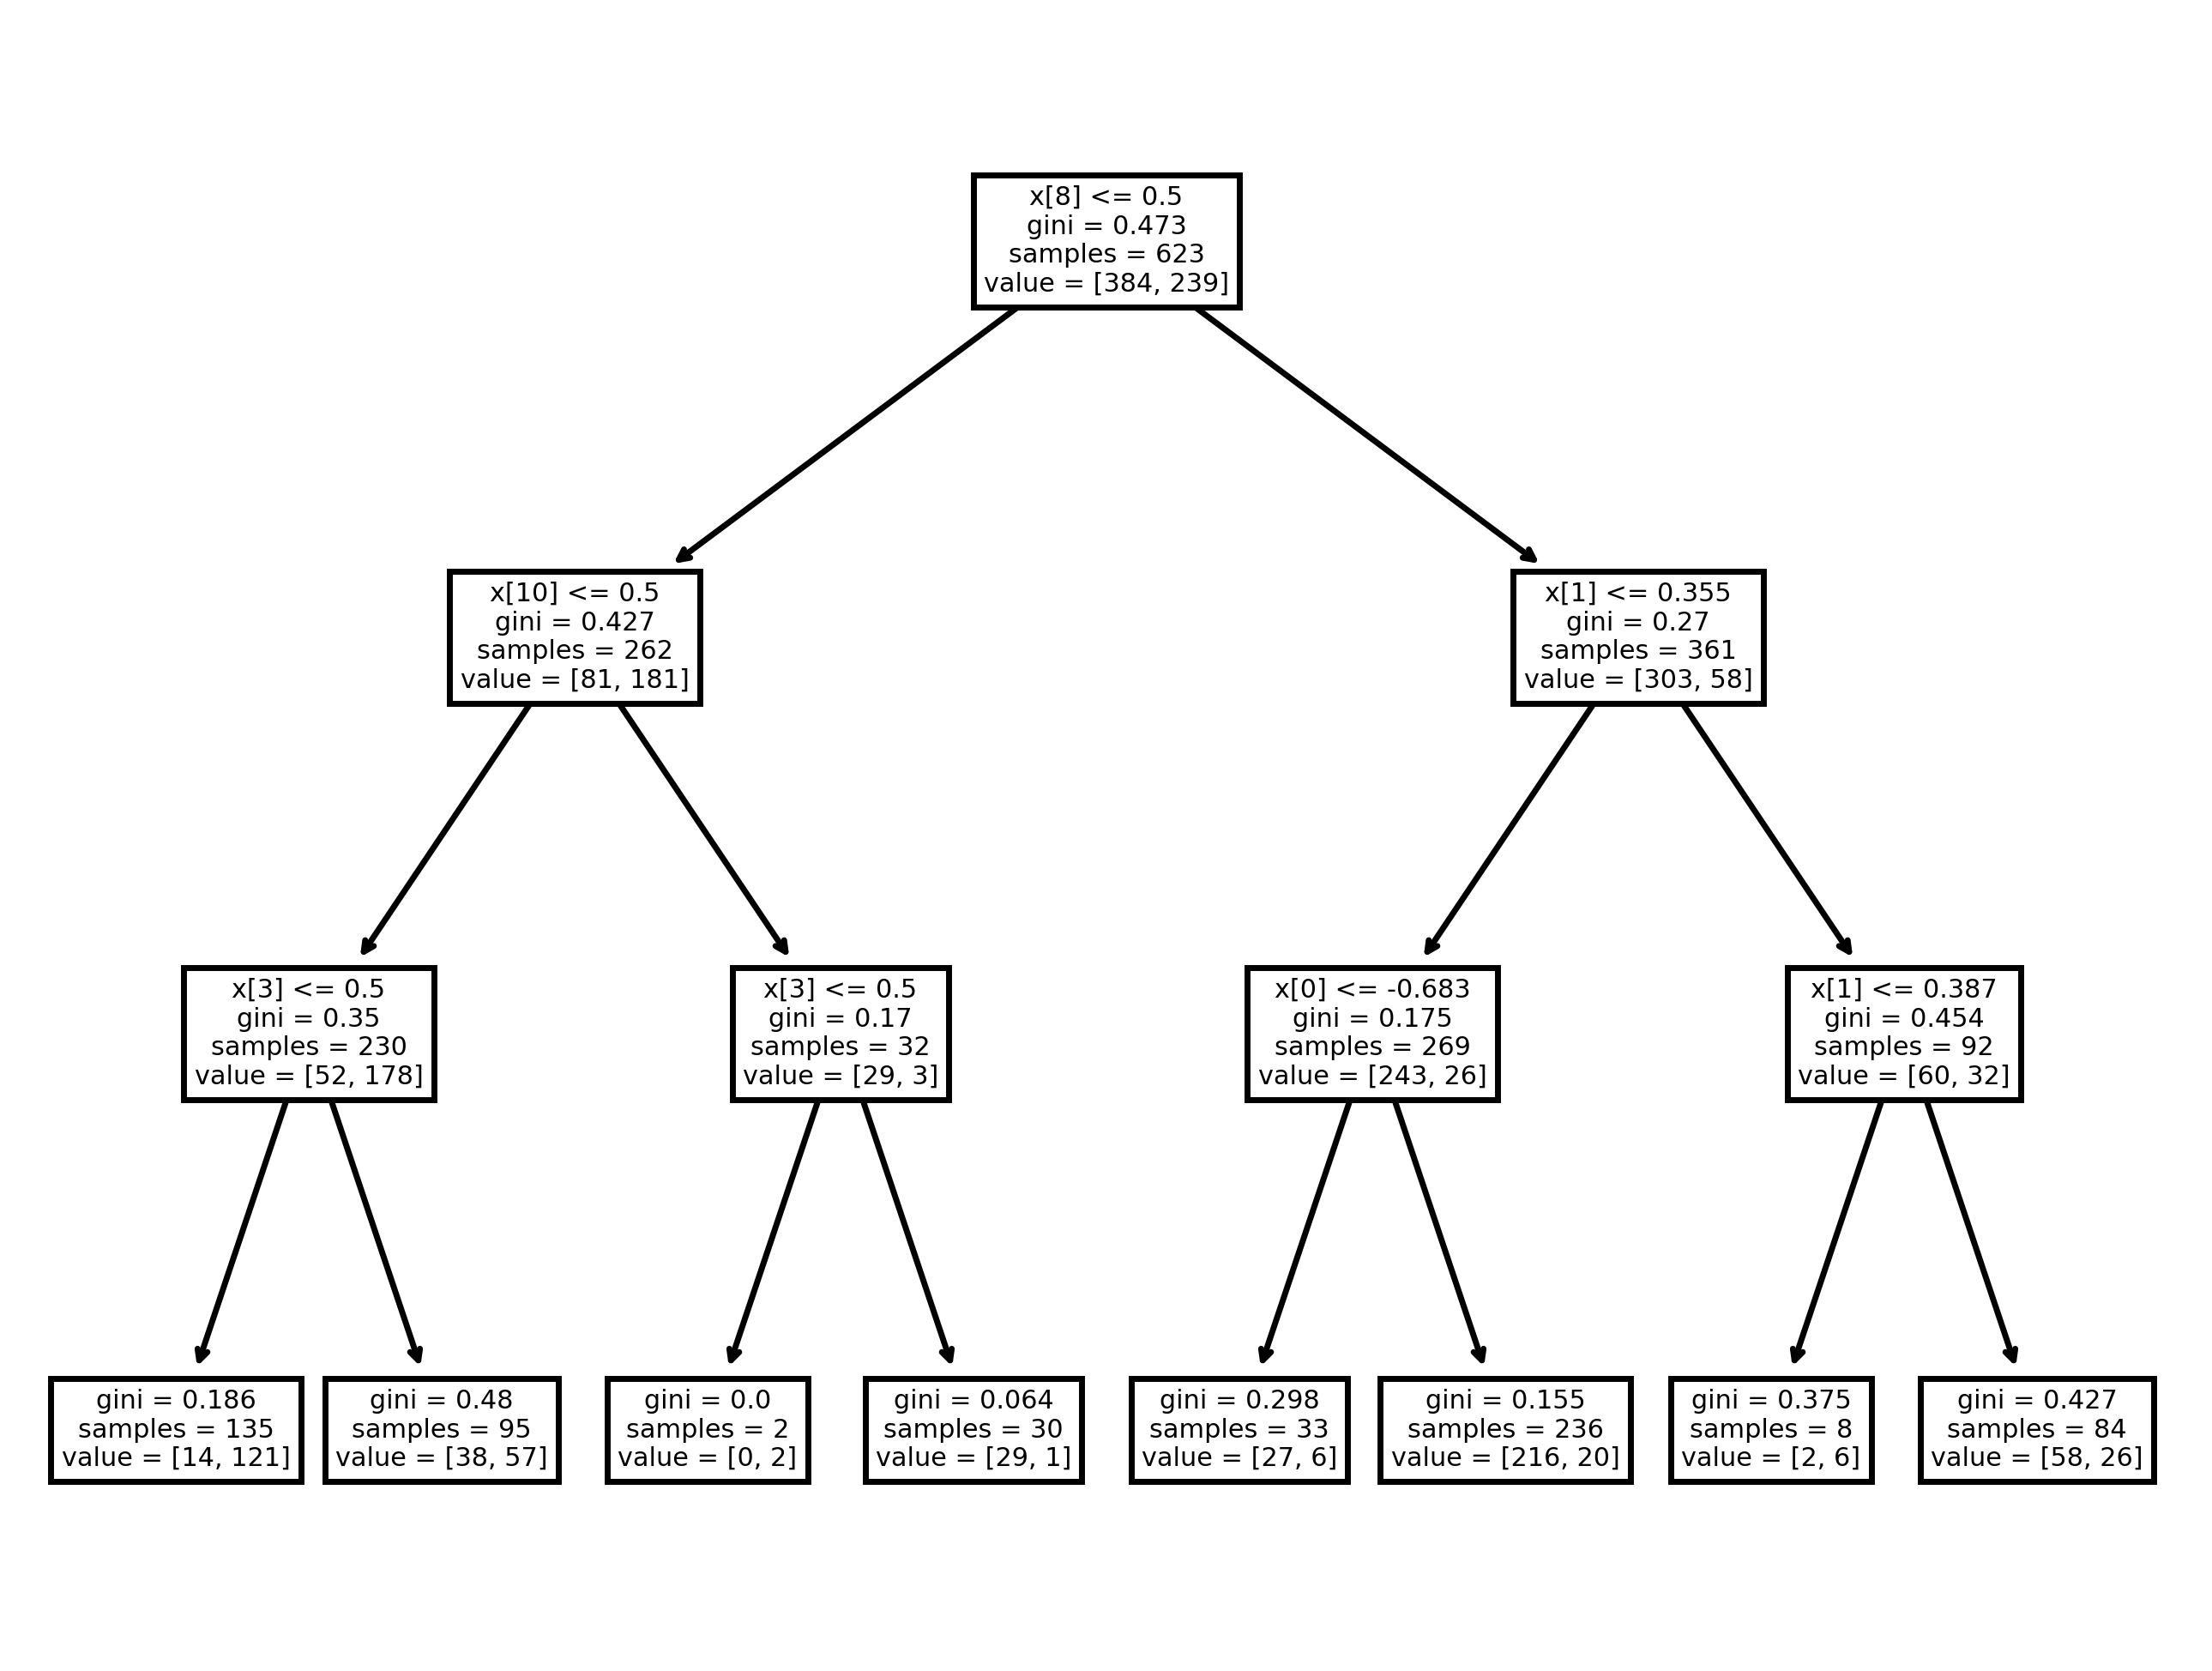

In [72]:
plt.figure(dpi=500)

plot_tree( tree )

plt.show()

## Random Forest
- weak tree * n
- 다양성 추가!<br>
    => feature를 랜덤하게 샘플링 함<br>
    => 각 나무를 훈련시킬 때 사용하는 데이터를 다르게 샘플링 함<br>

In [73]:
from sklearn.ensemble import RandomForestClassifier

# 배깅 => 여러 모델을 병렬적으로 만들어서 결과를 합침
# 부스트 => 여러 모델을 순차적으로 개선시켜가면서 이어감 ex) XGBoost : 부스트 모델 중 성능 좋은 모델(사이킷런에 없음 추가 라이브러리 설치 필요)

In [74]:
RandomForestClassifier

sklearn.ensemble._forest.RandomForestClassifier

In [75]:
params = {'max_depth':[3,5,10,20],
        'min_samples_leaf':[1,5,10,30]}

grid_rf = GridSearchCV( RandomForestClassifier(random_state=1), params, cv=5 )

grid_rf.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [3, 5, 10, 20],
                         'min_samples_leaf': [1, 5, 10, 30]})

In [76]:
grid_rf.best_params_

{'max_depth': 10, 'min_samples_leaf': 5}

In [83]:
rf = RandomForestClassifier( max_depth=10 )
grid_rf.fit(train_x, train_y)
grid_rf.score(valid_x,valid_y)

0.835820895522388

In [84]:
grid_rf.predict(test_final[feature_names])


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [85]:
rf_result = pd.DataFrame( test_final['PassengerId'] )
rf_result['Survived'] = grid_rf.predict( test_final[feature_names] )

In [86]:
rf_result.to_csv('./rf_result.csv', index=False)

In [87]:
# EDA
# feature engineering
    # 스케일링
    # 인코딩
# 하이퍼 파라미터(grid_search)
# 모델 생성
# 훈련
# 검증, 예측

# 회귀모델

- 선형 회귀 모델
- 생성
- 훈련
- RMSE, r-square


- 머신러닝
- target 있나, 없나
=> 있다 : 지도 학습
    => target 카테고리나, 연속된 숫자
        카테고리 : 분류 모델(classification)
        연속된 숫자 : 회귀 모델
=> 없음 : 비지도 학습

In [88]:
from sklearn.datasets import load_diabetes

In [104]:
temp = load_diabetes()
diabete_df = pd.DataFrame(temp['data'], columns=temp['feature_names'])

In [105]:
diabete_df['target'] = temp['target']

In [106]:
diabete_df

age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017293 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081413  0.083740  0.027809  0.173816   

           s4        s5        s6  target  
0   -0.002592  0.019907 -0.017646   151.0  
1   -0.039493 -0.068332 -0.092204    75.0  
2   -0.002592  0.002861 -0.025930   141.0  
3    0.034309  0.022688 -0.009362   206.0  
4   -0.002592 -0.031988 -0.046641   135.0  
..        ...       ...       ...     ...  
437 -0.002592  0.031193  0.007207   178.0  
438  0.034309 -0.018114  0.044485   104.0  
439 -0.011080 -0.046883  0.015491   132.0  
440  0.026560  0.044529 -0.025930   220.0  
441 -0.039493 -0.004222  0.003064    57.0  

[442 rows x 11 columns]

<Figure size 640x480 with 0 Axes>

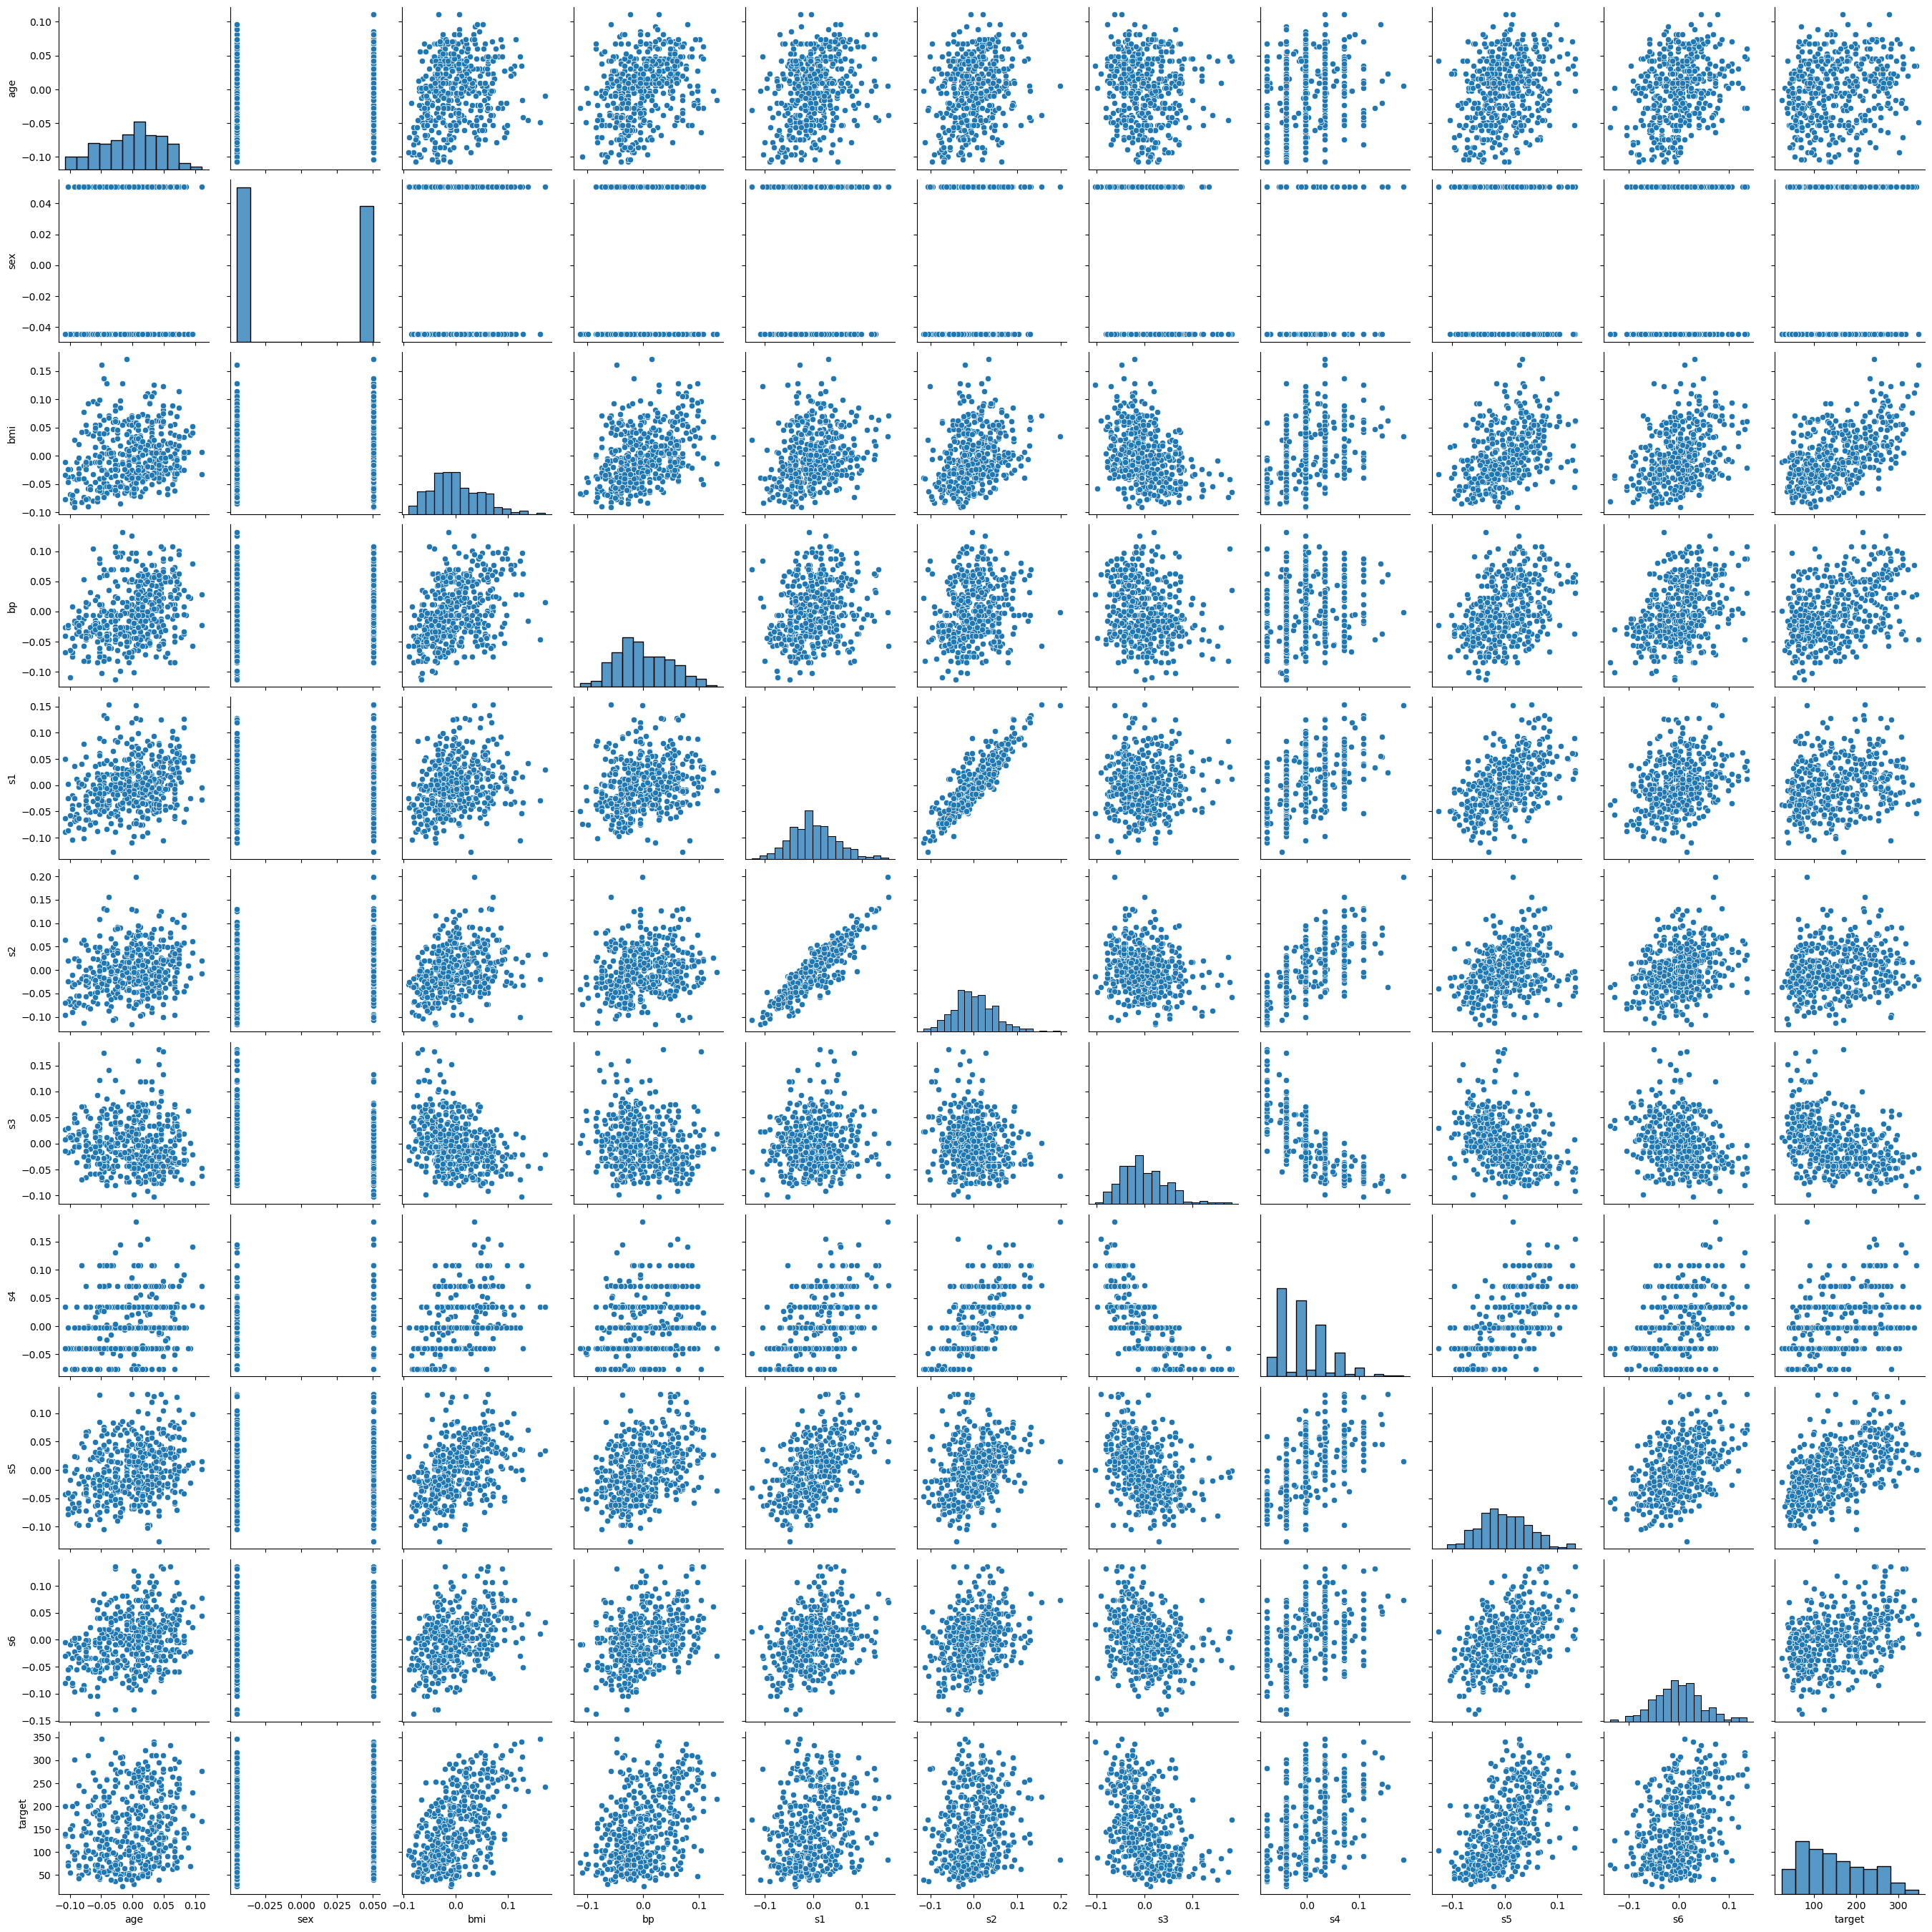

In [107]:
plt.figure()

sns.pairplot(diabete_df)

plt.show()

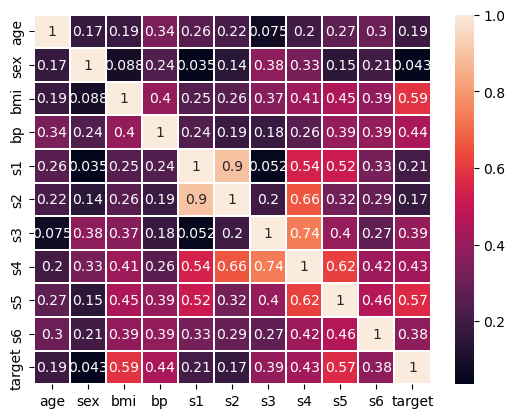

In [129]:
temp = np.abs( diabete_df.corr() )

plt.figure()

sns.heatmap(temp, annot=True, lw=0.1)

plt.show()

선형 회귀 분석
-  가정 : feature와 target간에 선형관계를 가진다!
- y = a1 * x1 + a2 * x2 + ... + b

In [113]:
from sklearn.linear_model import LinearRegression

In [118]:
# feature // target
X = diabete_df.iloc[:,:-1]
y = diabete_df['target']

# train // valid
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=1)

# 모델 생성
lr = LinearRegression()

# 훈련
lr.fit(train_x, train_y)

# 검증
# 분류 모델 => accuracy ( 0 ~ 1 )
# 회귀 모델 => 실제 정답과 예측값 사이의 '오차'
#          => R-square (모델이 데이터를 얼마나 잘 설명하는지 통계적 계산, 0 ~ 1)
lr.score(valid_x, valid_y)

0.43845439143447806

In [124]:
# 오차를 계산해 보자!
# rmse
((lr.predict(valid_x) - valid_y) ** 2).mean() ** 0.5

from sklearn.metrics import mean_squared_error

mean_squared_error( valid_y, lr.predict(valid_x) ) ** 0.5

53.17033023617667

### coef_ : 회귀계수

In [117]:
pd.Series( lr.coef_, index=train_x.columns )

age    -13.304511
sex   -238.040817
bmi    582.217037
bp     345.717423
s1    -647.574864
s2     340.868084
s3      90.177664
s4     217.612682
s5     664.559992
s6      46.123690
dtype: float64

In [133]:
# s1 & s2 중 하나를 제거하고 다시 모델을 만들어 보자
X2 = X.drop('s2', axis=1)
train_x, valid_x, train_y, valid_y = train_test_split(X2, y, test_size=0.3, random_state=1)

# 모델 생성
lr2 = LinearRegression()

# 훈련
lr2.fit(train_x, train_y)
lr2.predict(valid_x)

# RMSE
mean_squared_error(valid_y, lr2.predict(valid_x)) ** 0.5

53.40595656057828

In [136]:
# lr2에서 회귀 계수들 살펴보자!
pd.Series( lr2.coef_, index=train_x.columns)

age    -11.535129
sex   -234.830244
bmi    589.487971
bp     342.456517
s1    -240.883763
s3     -73.141332
s4     193.601798
s5     508.575948
s6      49.664190
dtype: float64

In [137]:
# 선형 회귀
# KNN
# RF

# 자전거 수요 예측
- 기계적으로 하자!

In [141]:

path = r'C:\Users\user\Desktop\실습 데이터\자전거 대여 데이터\train.csv'
train_df = pd.read_csv(path)

path= r'C:\Users\user\Desktop\실습 데이터\자전거 대여 데이터\test.csv'
test_df = pd.read_csv(path)

In [143]:
train_df

datetime  season  holiday  workingday  weather   temp  \
0      2011-01-01 00:00:00       1        0           0        1   9.84   
1      2011-01-01 01:00:00       1        0           0        1   9.02   
2      2011-01-01 02:00:00       1        0           0        1   9.02   
3      2011-01-01 03:00:00       1        0           0        1   9.84   
4      2011-01-01 04:00:00       1        0           0        1   9.84   
...                    ...     ...      ...         ...      ...    ...   
10881  2012-12-19 19:00:00       4        0           1        1  15.58   
10882  2012-12-19 20:00:00       4        0           1        1  14.76   
10883  2012-12-19 21:00:00       4        0           1        1  13.94   
10884  2012-12-19 22:00:00       4        0           1        1  13.94   
10885  2012-12-19 23:00:00       4        0           1        1  13.12   

        atemp  humidity  windspeed  casual  registered  count  
0      14.395        81     0.0000       3          13     16  
1      13.635        80     0.0000       8          32     40  
2      13.635        80     0.0000       5          27     32  
3      14.395        75     0.0000       3          10     13  
4      14.395        75     0.0000       0           1      1  
...       ...       ...        ...     ...         ...    ...  
10881  19.695        50    26.0027       7         329    336  
10882  17.425        57    15.0013      10         231    241  
10883  15.910        61    15.0013       4         164    168  
10884  17.425        61     6.0032      12         117    129  
10885  16.665        66     8.9981       4          84     88  

[10886 rows x 12 columns]

<Figure size 500x300 with 0 Axes>

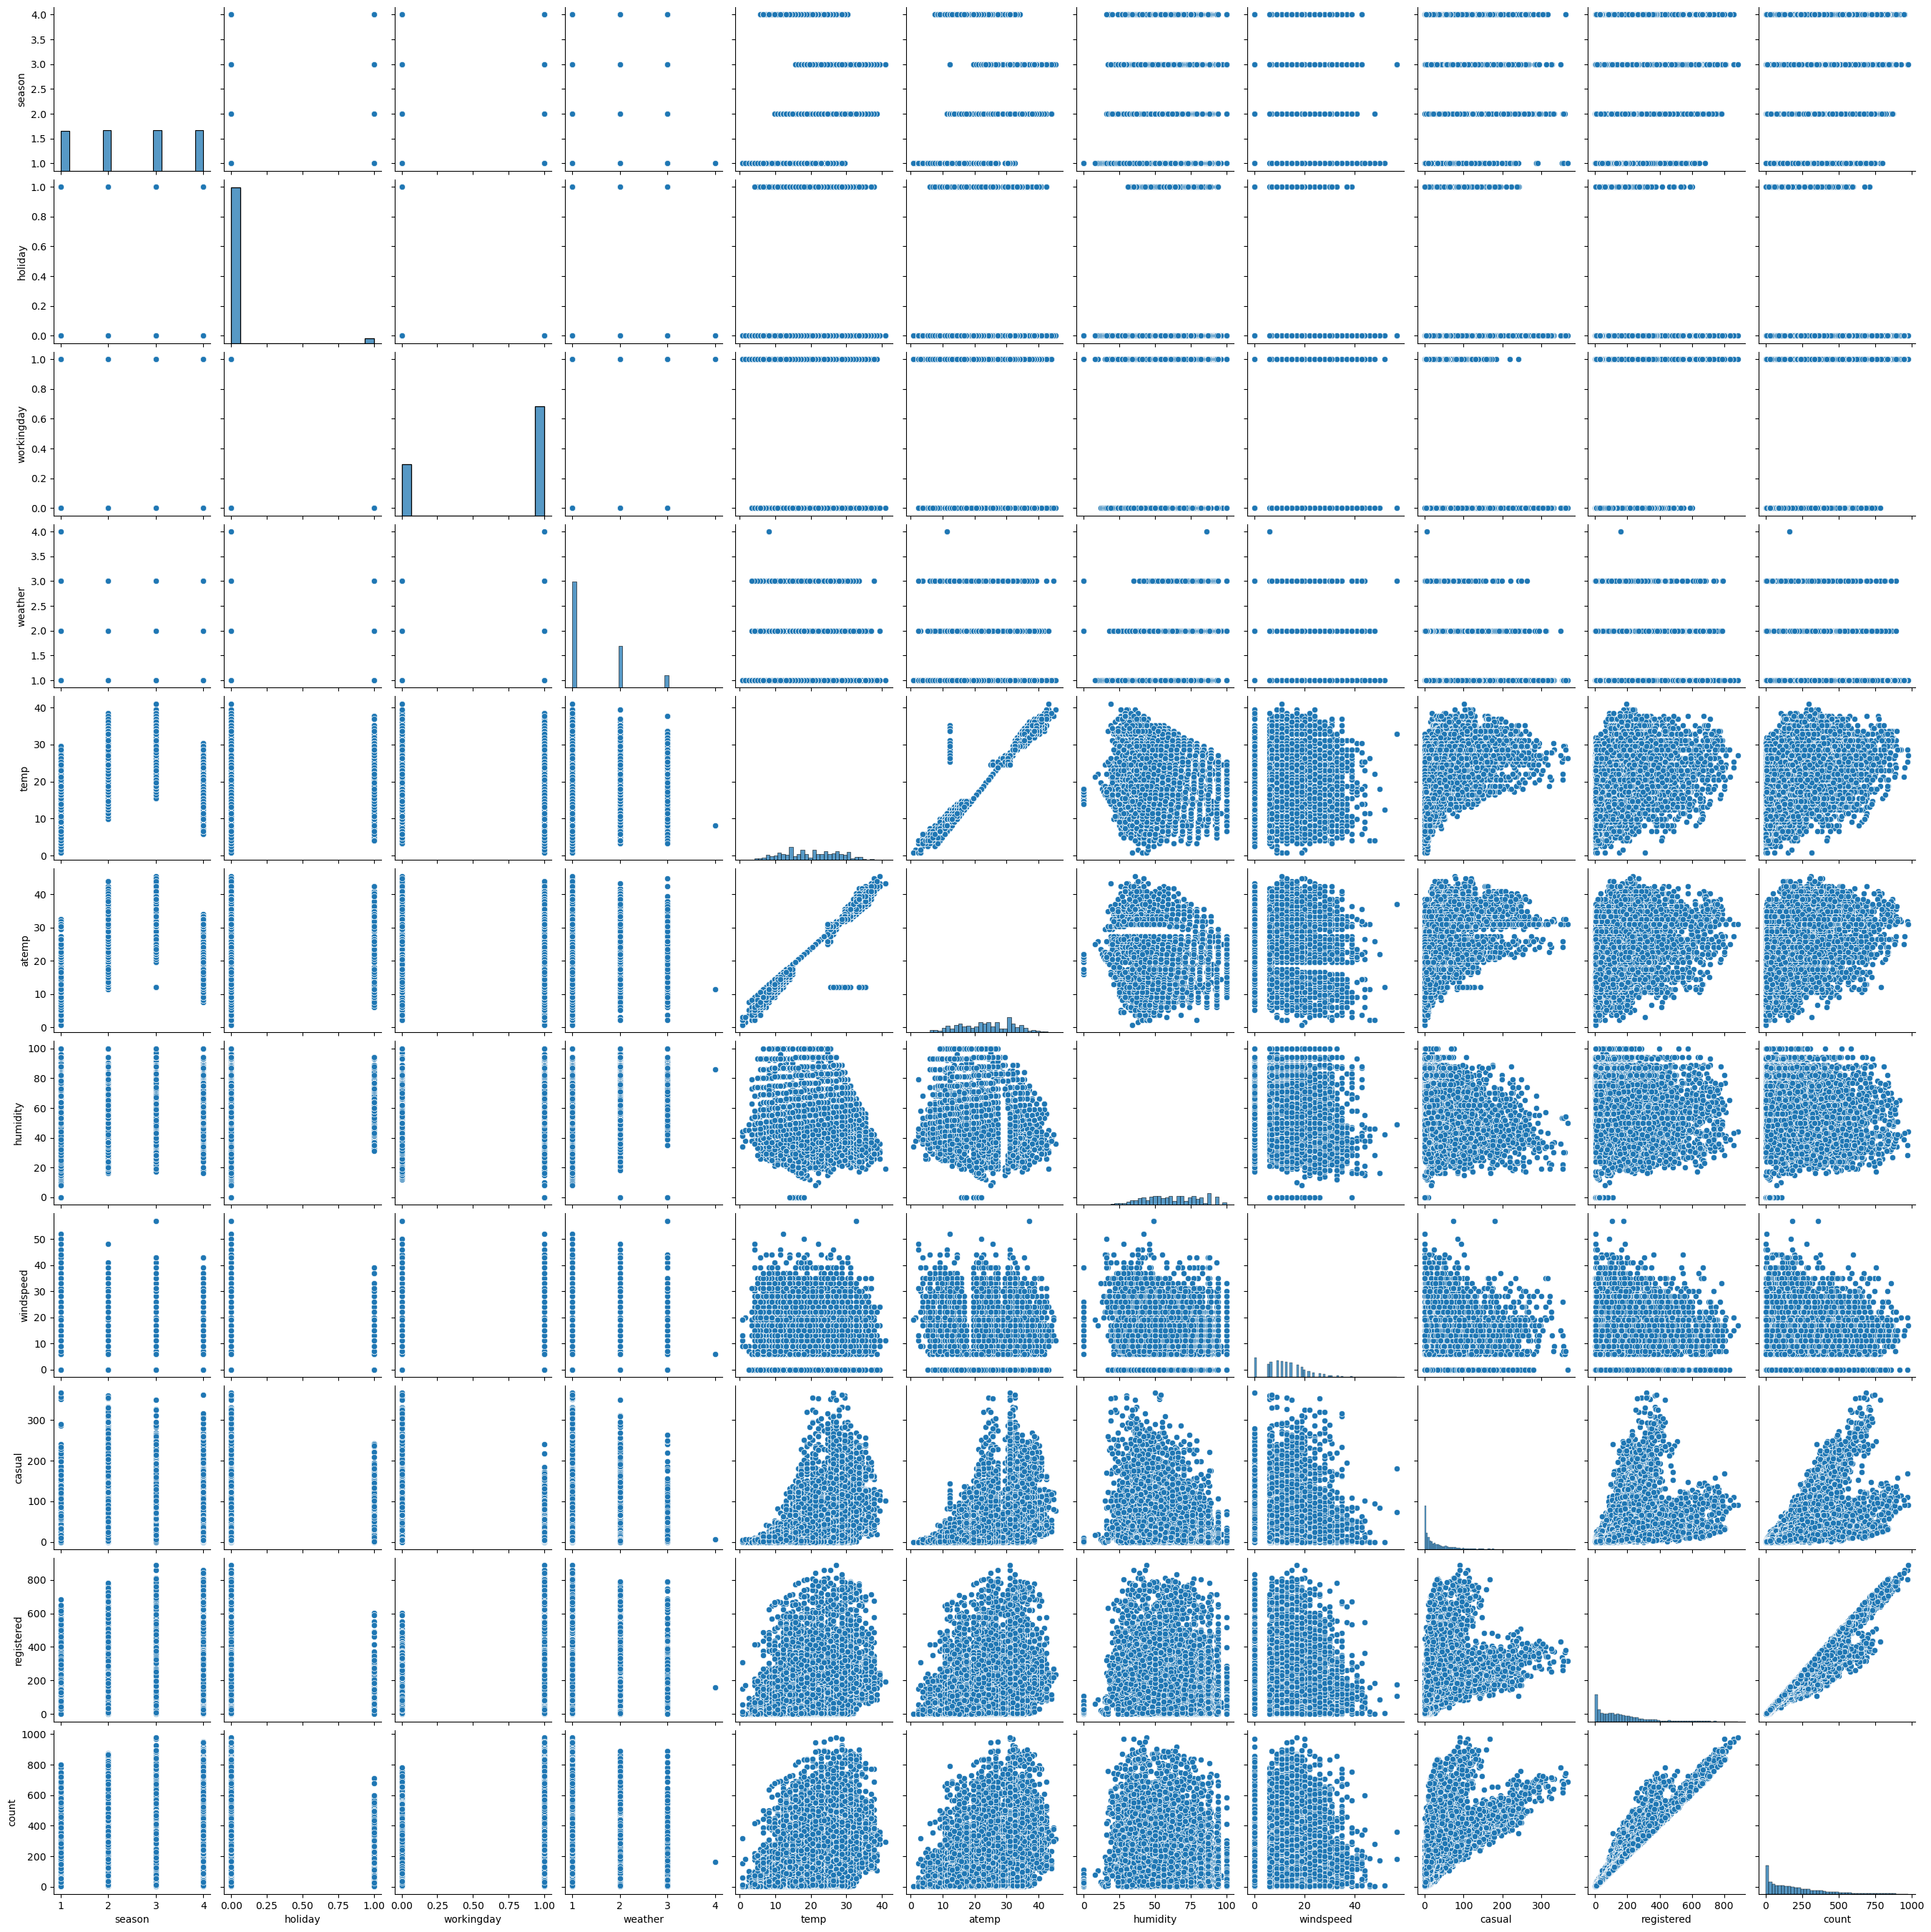

In [144]:
plt.figure(figsize=(5,3))

sns.pairplot(train_df)

plt.show()

In [152]:
train_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [153]:
test_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [157]:
train_df.describe()

season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count  
count  10886.000000  
mean     191.574132  
std      181.144454  
min        1.000000  
25%       42.000000  
50%      145.000000  
75%      284.000000  
max      977.000000

### datetime

In [161]:
train_df['datetime2'] = pd.to_datetime(train_df['datetime'])
test_df['datetime2'] = pd.to_datetime(test_df['datetime'])

In [167]:
train_df['year'] = train_df['datetime2'].dt.year
train_df['month'] = train_df['datetime2'].dt.month
# train_df['day'] = train_df['datetime2'].dt.day
train_df['hour'] = train_df['datetime2'].dt.hour

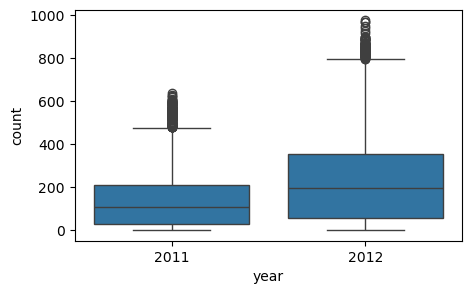

In [179]:
plt.figure(figsize=(5,3))

sns.boxplot(train_df, x='year', y='count')

plt.show()

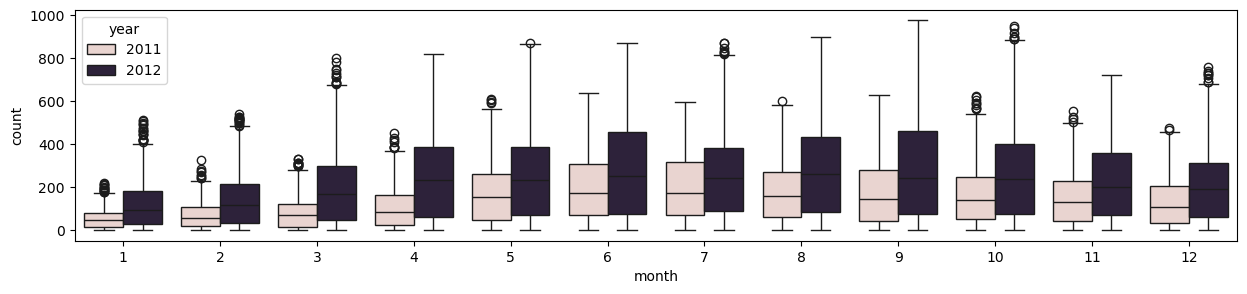

In [177]:
plt.figure(figsize=(15,3))

sns.boxplot(train_df, x='month', y='count', hue='year')

plt.show()

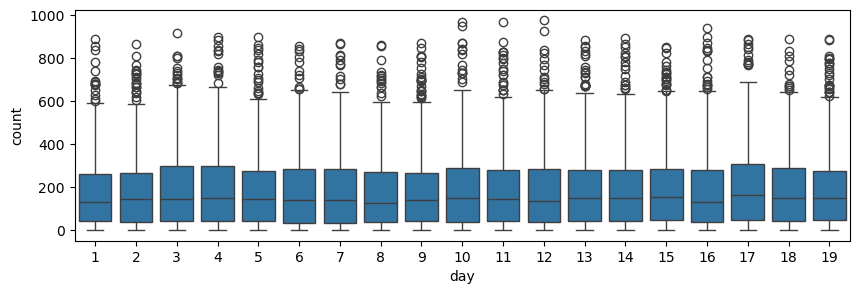

In [175]:
plt.figure(figsize=(10,3))

sns.boxplot(train_df, x='day', y='count')

plt.show()

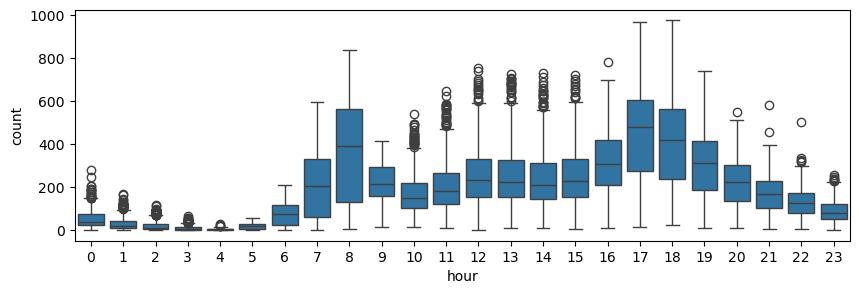

In [176]:
plt.figure(figsize=(10,3))

sns.boxplot(train_df, x='hour', y='count')

plt.show()

In [180]:
test_df['year'] = test_df['datetime2'].dt.year
test_df['month'] = test_df['datetime2'].dt.month
test_df['hour'] = test_df['datetime2'].dt.hour

In [183]:
# feature engineering
    # 스케일링 : 'temp', 'humidity', 'windspeed', 'month', 'hour'
    # 인코딩 : 'season', 'holiday', 'workingday', 'weather', 'year'

In [189]:
# 스케일링
from sklearn.preprocessing import StandardScaler

standard_sc = StandardScaler()
# 어떻게 스케일링 할것인지 훈련
standard_sc.fit( train_df[['temp', 'humidity', 'windspeed', 'month', 'hour']] )
# 실제 훈련한 것을 바탕으로 실행
train_df[['temp_s', 'humidity_s', 'windspeed_s', 'month_s', 'hour_s']] \
    = standard_sc.transform( train_df[['temp', 'humidity', 'windspeed', 'month', 'hour']] )

In [220]:
# test 셋도 스케일링
test_df[['temp_s', 'humidity_s', 'windspeed_s', 'month_s', 'hour_s']] \
    = standard_sc.transform( test_df[['temp', 'humidity', 'windspeed', 'month', 'hour']] )

In [221]:
# 인코딩 : 'season', 'holiday', 'workingday', 'weather', 'year'
train_final = pd.get_dummies( train_df, columns=['season', 'weather', 'year'], drop_first=True,
               dtype='int' )

test_final = pd.get_dummies( test_df, columns=['season', 'weather', 'year'], drop_first=True,
               dtype='int' )

In [222]:
train_final.columns

feature_names = ['temp_s', 'humidity_s', 'windspeed_s', 'month_s',
        'hour_s', 'season_2', 'season_3', 'season_4', 'weather_2', 'weather_3',
       'weather_4', 'year_2012', 'holiday', 'workingday']

In [223]:
train_final[feature_names]

temp_s  humidity_s  windspeed_s   month_s    hour_s  season_2  \
0     -1.333661    0.993213    -1.567754 -1.603121 -1.668944         0   
1     -1.438907    0.941249    -1.567754 -1.603121 -1.524341         0   
2     -1.438907    0.941249    -1.567754 -1.603121 -1.379739         0   
3     -1.333661    0.681430    -1.567754 -1.603121 -1.235137         0   
4     -1.333661    0.681430    -1.567754 -1.603121 -1.090534         0   
...         ...         ...          ...       ...       ...       ...   
10881 -0.596935   -0.617666     1.617227  1.590639  1.078500         0   
10882 -0.702182   -0.253919     0.269704  1.590639  1.223102         0   
10883 -0.807428   -0.046064     0.269704  1.590639  1.367704         0   
10884 -0.807428   -0.046064    -0.832442  1.590639  1.512307         0   
10885 -0.912675    0.213755    -0.465608  1.590639  1.656909         0   

       season_3  season_4  weather_2  weather_3  weather_4  year_2012  \
0             0         0          0          0          0          0   
1             0         0          0          0          0          0   
2             0         0          0          0          0          0   
3             0         0          0          0          0          0   
4             0         0          0          0          0          0   
...         ...       ...        ...        ...        ...        ...   
10881         0         1          0          0          0          1   
10882         0         1          0          0          0          1   
10883         0         1          0          0          0          1   
10884         0         1          0          0          0          1   
10885         0         1          0          0          0          1   

       holiday  workingday  
0            0           0  
1            0           0  
2            0           0  
3            0           0  
4            0           0  
...        ...         ...  
10881        0           1  
10882        0           1  
10883        0           1  
10884        0           1  
10885        0           1  

[10886 rows x 14 columns]

In [224]:
X = train_final[feature_names]
y = train_final['count']

from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split( X, y, test_size=0.3, random_state=7 )

In [225]:
# 하이퍼 파라미터
# 모델생성
# 훈련
# 예측, 검증

from sklearn.linear_model import LinearRegression

# 생성
lr = LinearRegression()
# 훈련
lr.fit(train_x, train_y)
# RMSE, r-squre
lr.score(valid_x, valid_y)

0.3926220083682984

In [226]:
mean_squared_error(valid_y, lr.predict(valid_x)) ** 0.5

140.91583110641452

In [227]:
# random forest
from sklearn.ensemble import RandomForestRegressor

# 하이퍼파라미터 => grid search
params = {'max_depth':[3,5,10,20],
        'min_samples_leaf':[1,10,20,30]}

# 모델 생성
grid_rfr = GridSearchCV(RandomForestRegressor(random_state=1), params, cv=5)

# 훈련
grid_rfr.fit(train_x, train_y)

# 검증 및 에측
grid_rfr.score(valid_x, valid_y)

0.9406507878318862

In [228]:
grid_rfr.best_params_

{'max_depth': 20, 'min_samples_leaf': 1}

In [229]:
# rmse
mean_squared_error(valid_y, grid_rfr.predict(valid_x)) ** 0.5

44.04917105069677

In [230]:
grid_rfr.predict(test_final[feature_names])

array([ 11.29,   5.57,   4.06, ..., 182.83, 127.12,  71.04])

In [231]:
# EDA
# feature engineering
    # 스케일링
    # 인코딩
# 하이퍼 파라미터 세팅
# 모델 생성
# 훈련
# 검증 및 예측